# Finance Notebooks #
## Prezzi e rendimenti ##

Prezzi e rendimenti costituiscono la base di qualunque analisi di serie finanziarie! Utilizziamo **python** (https://www.python.org/) come linguaggio di programmazione per svolgere un'analisi introduttiva a questi concetti, avvalendoci di **pandas** (http://pandas.pydata.org/) come strumento di raccolta e manipolazione dei dati, **bqplot** (https://bqplot.readthedocs.io/en/latest/index.html) per la visualizzazione e **Jupyter Widgets** (https://ipywidgets.readthedocs.io/en/stable/) per l'interazione. Prima di tutto, importiamo un po' di moduli per iniziare la nostra analisi.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import bqplot as bq

A questo punto, scegliamo qualche azione da analizzare. Prendiamo: **Apple** (AAPL), **Alphabet** (la società di Google, GOOGL), **Microsoft** (MSFT), **McDonald's** (MCD), **Coca-Cola** (KO). Tre azioni del settore tecnologico e due del comparto alimentare. 

In [2]:
# I tickers delle azioni scelte
STOCKS = ['AAPL', 'GOOGL', 'MSFT', 'MCD', 'KO']

Ora, scarichiamo i prezzi dal sito **Macrotrends**. (Sempre più complicato trovare serie finanziarie *free* su internet, al momento Yahoo!. Google e Morningstar sembrano non disponibili).

In [3]:
# pandas ora legge direttamente i file csv scaricati da internet, fornendo un url
def download_px(tickers):
    """ Download csv files with prices for each ticker and merge the in a pandas DataFrame."""
    l = []
    for t in tickers:
        url = 'http://download.macrotrends.net/assets/php/stock_data_export.php?t={}'.format(t)
        df = pd.read_csv(url, header=0, index_col=0, usecols=[0, 4], skiprows=10, parse_dates=True)
        df.columns = [t]
        l.append(df)
    return(pd.concat(l, axis=1))

px = download_px(STOCKS)

Poi prendiamo un ragionevole sottoinsieme di dati, diciamo più o meno gli ultimi dieci anni, avvalendoci delle ottime funzionalità di manipolazione delle date di **pandas**. Mostriamo i primi...

In [4]:
# Facciamo partire la serie dall'ultimo fine mese di dieci anni da oggi (n=121)
prices = px.loc[(pd.Timestamp.today() - pd.tseries.offsets.MonthEnd(n=121)).strftime('%m-%d-%Y'):pd.Timestamp.today().strftime('%m-%d-%Y'), :]
prices.head()

,AAPL,GOOGL,MSFT,MCD,KO
date,,,,,
2008-10-31,13.6210,180.2364,17.3877,42.6857,16.2809
2008-11-03,13.5413,173.7814,17.6136,42.0225,16.7945
2008-11-04,14.0515,184.0381,18.3221,42.5752,17.0088
2008-11-05,13.0779,171.6499,17.1931,41.2636,16.5284
2008-11-06,12.5462,166.1228,16.2587,39.9151,16.4398


...e gli ultimi valori del periodo.

In [5]:
prices.tail()

,AAPL,GOOGL,MSFT,MCD,KO
date,,,,,
2018-11-15,191.41,1071.05,107.28,183.56,49.74
2018-11-16,193.53,1068.27,108.29,187.59,50.17
2018-11-19,185.86,1027.42,104.62,186.72,50.51
2018-11-20,176.98,1030.45,101.71,183.71,49.38
2018-11-21,176.78,1043.43,103.11,182.72,48.73


A questo punto, creiamo un grafico dei prezzi e rendiamolo un po' interattivo consentendo di selezionare le azioni da mostrare con delle **checkbox**.

In [6]:
# Costruiamo una checkbox per ogni titolo
chks_1 = [widgets.Checkbox(description=d, value=True) for d in prices.columns]

# Costruiamo il grafico
x_sc_1 = bq.DateScale()
y_sc_1 = bq.LinearScale()
lines_1 = bq.Lines(x=prices.index, y=[prices[c] for c in prices.columns[[cb.value for cb in chks_1]]], scales={'x': x_sc_1, 'y': y_sc_1},
                   display_legend=True, colors=[bq.colorschemes.CATEGORY10[prices.columns.get_loc(n)] for n in prices.columns],
                   labels=[c for c in prices.columns[[cb.value for cb in chks_1]]])
ax_x_1 = bq.Axis(scale=x_sc_1, grid_lines='solid', grid_color='#DDDDDD')
ax_y_1 = bq.Axis(scale=y_sc_1, orientation='vertical', grid_lines='solid', grid_color='#DDDDDD')
fig_1 = bq.Figure(marks=[lines_1], axes=[ax_x_1, ax_y_1], title='Andamento dei prezzi', legend_location='top-left', background_style={'fill': 'white'},
                  layout=widgets.Layout(width='60%'))

# Definiamo una funzione che aggiorna i grafici, la legenda e i colori a seconda delle checkbox selezionate
def update_plot_1(change):
    """ Update the chart with boolean value from checkboxes."""
    lines_1.y = [prices[c] for c in prices.columns[[cb.value for cb in chks_1]]]
    lines_1.labels = [c for c in prices.columns[[cb.value for cb in chks_1]]]
    lines_1.colors = [bq.colorschemes.CATEGORY10[prices.columns.get_loc(c)] for c in prices.columns[[cb.value for cb in chks_1]]]
    
# Intercettiamo gli eventi relativi alle checkbox
for cb in chks_1:
    cb.observe(update_plot_1, 'value')

# Definiamo il layout delle widget
box_1 = widgets.HBox(chks_1, layout=widgets.Layout(width='60%', top='10px', right='50px'))
widgets.VBox([box_1, fig_1])

**Alphabet** (Google) scambia in un intervallo di prezzi superiore rispetto alle altre azioni. Per poter confrontare tra di loro gli andamenti, è necessario normalizzare i prezzi, ad esempio ribasandoli a 100 in una data uguale per tutti $P_t$ mediante la formula $$\frac{100 * P}{P_t}$$ Costruiamo allora un grafico dei prezzi normalizzati, aggiungendo uno **slider** per poter modificare la data di ribasamento.

In [7]:
# Costruiamo lo slider e colleghiamolo alle date della serie storica
opts_2 = [d.strftime('%d-%m-%Y') for d in prices.index]
slider_2 = widgets.SelectionSlider(options=opts_2, description='Data', layout={'width': '60%', 'top': '10px', 'right': '50px'})

# Normalizziamo i prezzi utilizzando la formula sopra citata
nprices = 100 * prices / prices.loc[pd.to_datetime(slider_2.value, dayfirst=True), :]

# Costruiamo il grafico
x_sc_2 = bq.DateScale(date_format = "%y")
y_sc_2 = bq.LinearScale()
x_sec_2 = bq.LinearScale(min=0, max=1)
y_sec_2 = bq.LinearScale(min=0, max=1)
lines_2 = bq.Lines(x=nprices.index, y=[nprices[c] for c in nprices.columns], scales={'x': x_sc_2, 'y': y_sc_2},
                   display_legend=True, labels=[c for c in nprices.columns])
frac = (pd.to_datetime(slider_2.value, dayfirst=True) - nprices.index[0]) / (nprices.index[-1] - nprices.index[0])
vline_2 = bq.Lines(x=[frac, frac], y=[0, 1], scales={'x': x_sec_2, 'y': y_sec_2}, colors=['#AAAAAA'])
ax_x_2 = bq.Axis(scale=x_sc_2, grid_lines='solid', grid_color='#DDDDDD')
ax_x_sec_2 = bq.Axis(scale=x_sec_2, visible=False)
ax_y_2 = bq.Axis(scale=y_sc_2, orientation='vertical', grid_lines='solid', grid_color='#DDDDDD')
ax_y_sec_2 = bq.Axis(scale=y_sec_2, orientation='vertical', visible=False)
fig_2 = bq.Figure(marks=[lines_2, vline_2], axes=[ax_x_2, ax_x_sec_2, ax_y_2, ax_y_sec_2], title='Andamento normalizzato dei prezzi ({} = 100)'.format(slider_2.value),
                  legend_location='top-left', background_style={'fill': 'white'}, layout=widgets.Layout(width='60%'))

# Definiamo una funzione che aggiorna la base di normalizzazione dei prezzi, il grafico e il titolo in base ai valori dello slider
def update_plot_2(change):
    """ Update the chart with value from slider."""
    nprices = 100 * prices / prices.loc[pd.to_datetime(slider_2.value, dayfirst=True), :]
    frac = (pd.to_datetime(slider_2.value, dayfirst=True) - nprices.index[0]) / (nprices.index[-1] - nprices.index[0])
    lines_2.y = [nprices[c] for c in nprices.columns]
    vline_2.x = [frac, frac]
    fig_2.title = 'Andamento normalizzato dei prezzi ({} = 100)'.format(slider_2.value)

# Intercettiamo i valori dello slider
slider_2.observe(update_plot_2, 'value')

# Definiamo il layout delle widget
widgets.VBox([slider_2, fig_2])

Ma qual è il rendimento delle azioni nel periodo considerato? Una prima risposta viene dal **rendimento assoluto**, ossia la percentuale di apprezzamento dei titoli sull'intero periodo, calcolata come $$100 * (\frac{P_T}{P_0} - 1)$$ dove $P_T$ è il prezzo del titolo alla fine del periodo e $P_0$ quello all'inizio del periodo.

In [25]:
absolute_returns = (prices.iloc[-1, :] / prices.iloc[0, :] - 1).to_frame().T
absolute_returns.index = ['Rendimenti assoluti (%)']
absolute_returns.style.format('{:.2%}')

,AAPL,GOOGL,MSFT,MCD,KO
Rendimenti assoluti (%),1197.85%,478.92%,493.01%,328.06%,199.31%


Per poter confrontare i rendimenti con - ad esempio - altri investimenti, può essere comodo trasformare il rendimento assoluto in un dato annualizzato. Per far ciò, utilizziamo la formula del **rendimento composto annuo** $$100 * [(\frac{P_T}{P_0})^{\frac{365}{T}} - 1]$$ dove $P_T$ è il prezzo del titolo alla fine del periodo, $P_0$ quello all'inizio del periodo e $T$ è il numero dei giorni compresi nel periodo.

In [26]:
compound_returns = ((1 + absolute_returns) ** (pd.Timedelta(365, unit='D') / (prices.index[-1] - prices.index[0])) - 1)
compound_returns.index = ['Rendimenti composti annui (%)']
compound_returns.style.format('{:.2%}')

,AAPL,GOOGL,MSFT,MCD,KO
Rendimenti composti annui (%),29.01%,19.07%,19.35%,15.55%,11.51%


Ora costruiamo un grafico dei rendimenti, **assoluti** e **composti annui**, aggiungendo dei **radio button** per poter selezionare il tipo di rendimento da mostrare.

In [89]:
# Concateniamo per comodità i dataframe absolute_returns e compound_returns
df_3 = pd.concat([absolute_returns, compound_returns])

# Costruiamo i radio buttons per selezionare il tipo di rendimento da mostrare
opts_3 = [i for i in df_3.index]
radio_3 = widgets.RadioButtons(options=opts_3, description='Tipo rendimento', style={'description_width': 'initial'}, layout={'width': '60%', 'top': '10px'})

# Costruiamo un grafico a barre con le etichette delle percentuali
x_sc_3 = bq.OrdinalScale()
y_sc_3 = bq.LinearScale()
bars_3 = bq.Bars(x=df_3.columns, y=df_3.loc[radio_3.value, :], scales={'x': x_sc_3, 'y': y_sc_3},
                 colors=[bq.colorschemes.CATEGORY10[df_3.index.get_loc(radio_3.value)]])
labels_3 = bq.Label(x=df_3.columns, y=df_3.loc[radio_3.value, :], text=[f'{v:.2%}' for v in df_3.loc[radio_3.value, :]], scales={'x': x_sc_3, 'y': y_sc_3}, 
                    colors=[['#AAAAAA', '#666666'][df_3.index.get_loc(radio_3.value)]], align='middle', y_offset=15)
ax_x_3 = bq.Axis(scale=x_sc_3, grid_lines='solid', grid_color='#DDDDDD')
ax_y_3 = bq.Axis(scale=y_sc_3, orientation='vertical', tick_format='0%', grid_lines='solid', grid_color='#DDDDDD')
fig_3 = bq.Figure(marks=[bars_3, labels_3], axes=[ax_x_3, ax_y_3], title=radio_3.value, legend_location='top-right', background_style={'fill': 'white'},
                  layout=widgets.Layout(width='60%'))

# Definiamo una funzione per aggiornare il grafico, le etichette e il titolo
def update_plot_3(change):
    """ Update the chart with value from radio buttons."""
    bars_3.y = df_3.loc[radio_3.value, :]
    bars_3.colors = [bq.colorschemes.CATEGORY10[df_3.index.get_loc(radio_3.value)]]
    labels_3.y = df_3.loc[radio_3.value, :]
    labels_3.text = [f'{v:.2%}' for v in df_3.loc[radio_3.value, :]]
    labels_3.colors = [['#AAAAAA', '#666666'][df_3.index.get_loc(radio_3.value)]]
    fig_3.title = radio_3.value

# Intercettiamo i valori dei radio buttons
radio_3.observe(update_plot_3, 'value')

# Definiamo il layout delle widget
widgets.VBox([radio_3, fig_3])

Now, let's resample data into yearly percent returns.

In [30]:
yearly_returns = prices.resample('A').last().pct_change()
yearly_returns

,NASDAQ:AAPL,NASDAQ:GOOGL,NASDAQ:MSFT,NYSE:KO,NYSE:MCD
Date,,,,,
2007-12-31,NaN,NaN,NaN,NaN,NaN
2008-12-31,-0.569258,-0.555087,-0.453933,-0.262060,0.055678
2009-12-31,1.469237,1.015197,0.567901,0.258834,0.004020
2010-12-31,0.530897,-0.041959,-0.084318,0.153684,0.229340
2011-12-31,0.255642,0.087426,-0.069867,0.063869,0.307061
2012-12-31,0.313861,0.095184,0.028891,0.036306,-0.120801
2013-12-31,0.054328,0.584341,0.400599,0.139586,0.099989
2014-12-31,0.377168,-0.053947,0.241647,0.022029,-0.034319
2015-12-31,-0.046385,0.466118,0.194403,0.017527,0.260832


Then, let's plot the returns.

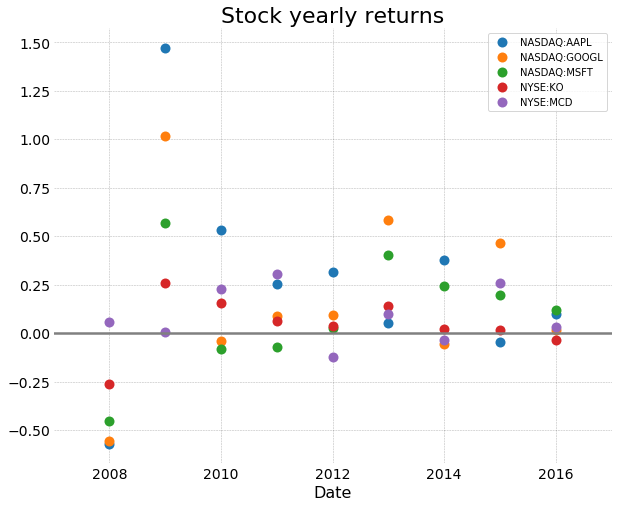

In [49]:
ax = yearly_returns.plot(figsize=(10, 8), title='Stock yearly returns', ls='', marker='o');
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 1)
ax.axhline(0, color='gray');

And let's see how returns averaged in the period. 

In [54]:
yearly_avgs = yearly_returns.mean().to_frame().T
yearly_avgs.index = ['Average Yearly Return (%)']
yearly_avgs

,NASDAQ:AAPL,NASDAQ:GOOGL,NASDAQ:MSFT,NYSE:KO,NYSE:MCD
Average Yearly Return (%),0.276201,0.179537,0.105041,0.043873,0.092456


Then we can compute yearly logarithmic returns over the period.

In [55]:
import numpy as np

yearly_log_returns = prices.resample('A').last().apply(np.log).diff()
yearly_log_returns

,NASDAQ:AAPL,NASDAQ:GOOGL,NASDAQ:MSFT,NYSE:KO,NYSE:MCD
Date,,,,,
2007-12-31,NaN,NaN,NaN,NaN,NaN
2008-12-31,-0.842246,-0.809876,-0.605013,-0.303893,0.054183
2009-12-31,0.903909,0.700717,0.449738,0.230186,0.004012
2010-12-31,0.425854,-0.042865,-0.088086,0.142960,0.206478
2011-12-31,0.227647,0.083813,-0.072428,0.061912,0.267781
2012-12-31,0.272970,0.090922,0.028481,0.035663,-0.128744
2013-12-31,0.052903,0.460168,0.336900,0.130665,0.095300
2014-12-31,0.320029,-0.055457,0.216438,0.021789,-0.034922
2015-12-31,-0.047495,0.382618,0.177646,0.017375,0.231772


Let's also plot log returns. 

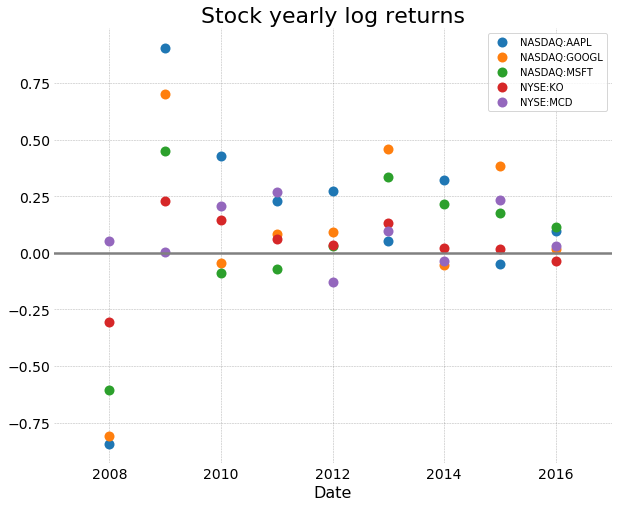

In [56]:
ax = yearly_log_returns.plot(figsize=(10, 8), title='Stock yearly log returns', ls='', marker='o');
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 1)
ax.axhline(0, color='gray');

Again, let's compute averages. Quite different from percent returns, aren't they?

In [57]:
yearly_log_avgs = yearly_log_returns.mean().to_frame().T
yearly_log_avgs.index = ['Average Yearly Log Return (%)']
yearly_log_avgs

,NASDAQ:AAPL,NASDAQ:GOOGL,NASDAQ:MSFT,NYSE:KO,NYSE:MCD
Average Yearly Log Return (%),0.156575,0.092048,0.061894,0.033458,0.080635


We always can transform percent returns into log returns:

In [58]:
(1 + yearly_returns).apply(np.log)

,NASDAQ:AAPL,NASDAQ:GOOGL,NASDAQ:MSFT,NYSE:KO,NYSE:MCD
Date,,,,,
2007-12-31,NaN,NaN,NaN,NaN,NaN
2008-12-31,-0.842246,-0.809876,-0.605013,-0.303893,0.054183
2009-12-31,0.903909,0.700717,0.449738,0.230186,0.004012
2010-12-31,0.425854,-0.042865,-0.088086,0.142960,0.206478
2011-12-31,0.227647,0.083813,-0.072428,0.061912,0.267781
2012-12-31,0.272970,0.090922,0.028481,0.035663,-0.128744
2013-12-31,0.052903,0.460168,0.336900,0.130665,0.095300
2014-12-31,0.320029,-0.055457,0.216438,0.021789,-0.034922
2015-12-31,-0.047495,0.382618,0.177646,0.017375,0.231772


And vice versa:

In [59]:
(yearly_log_returns).apply(np.exp) - 1

,NASDAQ:AAPL,NASDAQ:GOOGL,NASDAQ:MSFT,NYSE:KO,NYSE:MCD
Date,,,,,
2007-12-31,NaN,NaN,NaN,NaN,NaN
2008-12-31,-0.569258,-0.555087,-0.453933,-0.262060,0.055678
2009-12-31,1.469237,1.015197,0.567901,0.258834,0.004020
2010-12-31,0.530897,-0.041959,-0.084318,0.153684,0.229340
2011-12-31,0.255642,0.087426,-0.069867,0.063869,0.307061
2012-12-31,0.313861,0.095184,0.028891,0.036306,-0.120801
2013-12-31,0.054328,0.584341,0.400599,0.139586,0.099989
2014-12-31,0.377168,-0.053947,0.241647,0.022029,-0.034319
2015-12-31,-0.046385,0.466118,0.194403,0.017527,0.260832


If we plot daily returns, we can clearly see a different scale over time and across stocks. Let's try with **Apple** and **McDonald's**.

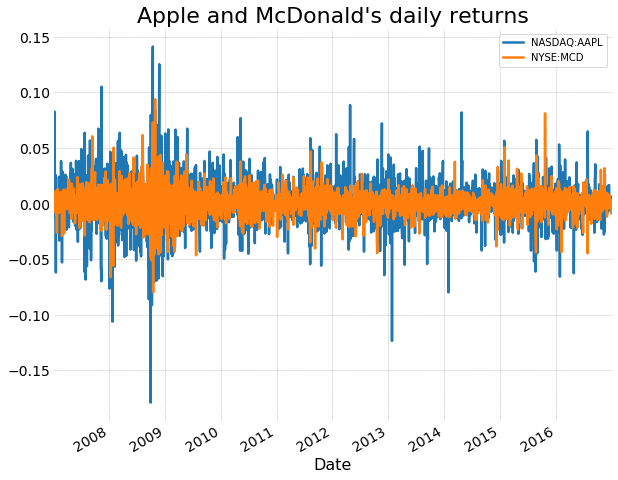

In [64]:
prices.loc[:, ['NASDAQ:AAPL', 'NYSE:MCD']].pct_change().plot(figsize=(10, 8), title="Apple and McDonald's daily returns")

That leads us to a new topic: volatility, i.e. variability of returns. But this is a topic which deserves a new anaysis. To be continued...